# Klasyfikacja ręcznie rysowanych symboli
## Krok 1: Przygotowanie danych
Pobieramy dataset ze strony, jest tam 10 folderów, gdzie każdy to kolejny symbol.


In [26]:
import os

dataset_path = 'dataset'    # należy pobrać dataset ze strony i dodać go do repo, nie waży dużo
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

results = {}

for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    files = os.listdir(folder_path)
    
    total_files = len(files)
    digit_files = len([f for f in files if f.startswith('digit')])
    drawn_files = len([f for f in files if f.startswith('drawn')])
    stamp_files = len([f for f in files if f.startswith('stamp')])
    
    results[folder] = {
        'total': total_files,
        'digit': digit_files,
        'drawn': drawn_files,
        'stamp': stamp_files
    }

for folder, counts in results.items():
    print(f"Folder: {folder}")
    print(f"  Liczba wszystkich plików: {counts['total']}")
    print(f"  Pliki zaczynające się od 'digit': {counts['digit']}")
    print(f"  Pliki zaczynające się od 'drawn': {counts['drawn']}")
    print(f"  Pliki zaczynające się od 'stamp': {counts['stamp']}")
    print("-" * 20)

Folder: anchor
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 19
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 9
--------------------
Folder: balloon
  Liczba wszystkich plików: 43
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 9
--------------------
Folder: bicycle
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 10
--------------------
Folder: envelope
  Liczba wszystkich plików: 44
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 10
--------------------
Folder: paper_boat
  Liczba wszystkich plików: 42
  Pliki zaczynające się od 'digit': 18
  Pliki zaczynające się od 'drawn': 16
  Pliki zaczynające się od 'stamp': 8
--------------------
Folder: peace_symbol
  Liczba wszystkich plików: 43
  Pliki zaczynające się

Widzimy, że każda klasa ma w okolicach 43/44 zdjęć więc ich ilość równo rozłożona na klasy, podział na zdjęcia typu digit, stamp oraz drawn również jest podobny na przestrzeni wszystkich symboli co nie budzi wątpliwości, przyjrzyjmy się przykładowym zdjęciom:

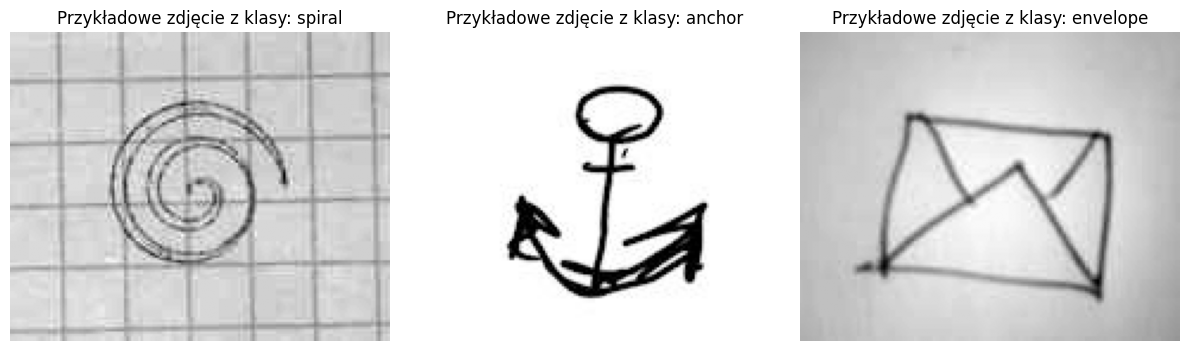

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
# wyświetlanie przykładowych obrazów z  datasetu
# Ścieżki do obrazów
image_paths = [
    'dataset/spiral/stamp05.jpg',
    'dataset/anchor/digit04.jpg',
    'dataset/envelope/drawn02.jpg'
]

# Tworzenie figury i osi
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Wyświetlanie każdego obrazu
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert('L')
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Przykładowe zdjęcie z klasy: {img_path.split("/")[1]}')

plt.tight_layout()
plt.show()


 Najlepsze są zdjęcia robione komputerowo, posiadają mało szumów i przedstawiają faktyczne kształty symboli które chcemy wrzucać do modelu. Nie możemy powiedzieć tego samego o zdjęciach wykonanych przez człowieka, gdzie słabe oświetlenie i kartka w kratkę drastycznie pogarsza jakość obrazu, będziemy musieli się jakoś pozbyć tych szumów.

## Krok 2: Preprocessing
Testowałem kilka podejść, jak usunąć wszelkie cienie tudzież kratki ze zdjęć robionych ręcznie i najlepszy wynik otrzymałem po wykorzystaniu transformaty fouriera aby usuwać kratki ze zdjęć. Działa ona na zasadzie że wysokie zmiany w jasności są interpretowane jako wysoka częstotliwość, a niewielkie zmiany- jako niska, po czym przy dostrojeniu odpowiednich parametrów usuwamy te skoki częstotliwości gdzie występuje linia z zeszytu a na koniec stosujemy progowanie, aby zostały jedynie wartości binarne, odróżniające kształt od tła. Wiadomo, w pewnym stopniu może to też zaburzyć sam symbol i tak też w niektórych momentach się dzieje, ale uznałem że będzie to nienajgorszy kompromis. Po fft zastosowałem dodatkowo tzw. operacje morfologiczne, które właśnie służą do wypełniania dziur, oraz usuwania pojedyńczych "plam" pikseli. Po przepuszczeniu zdjęcia przez fouriera, dokonujemy binaryzacji, czyli na podstawie progu zamieniamy piksele w obrazie wyłącznie na kolor czarny i biały i po normalizacji do przedziału -1,1 nasze zdjęcia powinny być gotowe do uczenia.

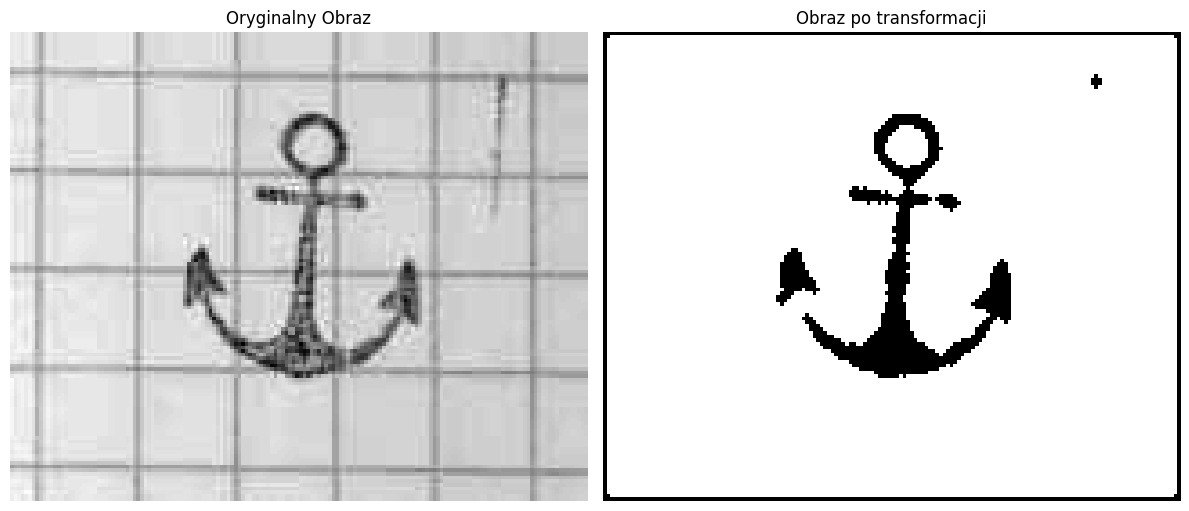

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import binary_closing, binary_opening

thresh = 99.3  # Próg procentowy do wykrywania pików
center_size = 15 # Rozmiar centralnego obszaru do ochrony

def apply_morphological_ops(x):
    x_np = x.squeeze().numpy()
    x_closed = binary_closing(x_np)
    x_opened = binary_opening(x_closed)
    return torch.from_numpy(x_opened).float().unsqueeze(0)


def remove_grid_fft(img):
    img_np = np.array(img.convert('L')) # kolor nie ma znaczenia, konwertujemy do skali szarości
    
    # transformacja fouriera
    f = np.fft.fft2(img_np)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    
    # Wykrywanie pików(lini kratki) jako lokalnych maksimów
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    local_max = cv2.dilate(magnitude_spectrum, kernel)
    peaks = (magnitude_spectrum == local_max)

    threshold = np.percentile(magnitude_spectrum, thresh)
    peaks &= (magnitude_spectrum > threshold)
    
    # Ochrona głównego kształtu (niskie częstotliwości)
    (rows, cols) = img_np.shape
    crow, ccol = rows // 2 , cols // 2
    peaks[crow-center_size:crow+center_size, ccol-center_size:ccol+center_size] = 0
    
    # usuwamy to co fft uznało za kratkę
    fshift[peaks] = 0.001
    
    # odwrotny fourier
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return Image.fromarray(img_back)

# Ścieżka do obrazu
path = r'dataset/anchor/stamp03.jpg'

# Definicja transformacji
transform = transforms.Compose([
    transforms.Resize((130, 160)),
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.6).float()),
    transforms.Lambda(apply_morphological_ops),
    transforms.Normalize((0.5,), (0.5,))
])


original_image = Image.open(path)

# Aplikowanie transformacji
transformed_tensor = transform(original_image)
image_to_show = transformed_tensor.squeeze()

# Wyświetlanie obrazów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Oryginalny Obraz')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_to_show, cmap='gray')
plt.title('Obraz po transformacji')
plt.axis('off')

plt.tight_layout()
plt.show()



Zdjęcia lepszej jakości zostają w lepszym stanie ale główna idea przetwarzania zostaje taka sama. Niektóre zdjęcia mimo wszystko są na tyle złej jakości, że kratki bywają ciemniejsze od narysowanego symbolu co mocno utrudnia ich usunięcie. Narazie pogodzimy się z tym faktem ale do przyszłych edycji dochodzi pomysł usunięcia ich z datasetu, wiem że jest on mały ale może te dosłownie kilka zdjęć mniej da nam lepszy wynik.

## Krok3: ładowanie danych
przepuszczamy nasze dane przez wspomniane transformacje i ładujemy je do dataloadera, który będzie nam wypuszczaść dane do modelu w batchach. W tym miejscu dzielimy je na dane treningowe, testowe i walidacyjne, oraz dokonujemy augmentacji(przesunięcia, obroty itd) na zbiorze  treningowym dla lepszych wyników.

In [29]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

batch_size = 32
img_height = 130
img_width = 160
dataset_dir = 'dataset'

class SymbolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
        
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        for cls_name in self.classes:
            class_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(class_dir):
                self.file_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def get_dataloaders(dataset_dir=dataset_dir, batch_size=batch_size, test_size=0.2, val_size=0.2):
    
    train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.RandomAffine(degrees=20, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.65).float()),
    transforms.Lambda(apply_morphological_ops),
    transforms.Normalize((0.5,), (0.5,))
])

    val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.65).float()),
    transforms.Lambda(apply_morphological_ops),
    transforms.Normalize((0.5,), (0.5,))
])

    # Utworzenie pełnego zbioru danych
    full_dataset = SymbolDataset(root_dir=dataset_dir)
    
    # Podział na zbiór treningowo-walidacyjny i testowy
    indices = list(range(len(full_dataset)))
    labels = full_dataset.labels
    
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=labels, random_state=67
    )
    
    # Podział zbioru treningowo-walidacyjnego na treningowy i walidacyjny
    train_val_labels = [labels[i] for i in train_val_indices]
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, stratify=train_val_labels, random_state=42
    )

    
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    class_names = full_dataset.classes
    return train_loader, val_loader, test_loader, class_names




## Krok 4: Model
Do tego zadania użyłem modelu simple cnn, którego sieci konwolucyjne (te co przechodzą z filtrem przez zdjęcie) są przeznaczone do tego typu danych. Zdjęcia wydają się dosyć proste więc uznałem że mało skomplikowany układ będzie wystarczający (na przestrzeni tego projektu dużo rzeczy można usprawnić i dopracować ale ze względu na brak czasu w ostatnim czasie bardziej skupiłem się na ogólnej idei), i użyłem warstw conv2d oraz maxpool z funkcją aktywacji Relu, które są przeznaczone do rozpoznawania kształtów (to zadanie troche przypomina mnist) a maxpool redukuje wymiary aby finalnie przejść do jedynie 10 cech.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
num_classes = 10

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Wyjście: (batch_size, 32, 65, 80)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Wyjście: (batch_size, 64, 32, 40)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Wyjście: (batch_size, 128, 16, 20)
        )        
        
        # rozmiar obrazów na przestrzeni tworzenia kodu się zmieniał, adaptive pool zawsze sprowadza do tego samego rozmiaru
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) 
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),    # żeby nie overfitować odrzucamy 30% 
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)        
        x = self.classifier(x)
        return x

Używane urządzenie: cuda


## Krok 5: Przygotowanie modelu i pętla treningowa
skoro mamy już model, możemy przystąpić do pętli treningowej i ewaluacji. Jako optymalizator wybrałem Adama, a funkcją straty będzie entropia krzyżowa, czyli taki standard bym powiedział. Ogółem próbowałem dostosować hiperparametry przy użyciu optuny (optymalizator, lr , dropout itd.) ale zajmowało to niesamowicie dużo czasu, mój laptop nie był w stanie przerobić tego a wyniki z części obliczeń jakie zrobiłem nie były znaczące dla przebiegu uczenia, więc porzuciłem ten pomysł i pozostałem przy Adamie, lr ustawiłem na 0,001 a dropout na 0.5. Co do optymalizatorów jeszcze to SGD oraz AdamW dawały gorsze wyniki więc jest jak jest.

### Na początku zdefiniowałem funkcje do pojedyńczej epoki oraz ewaluacji

In [31]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):

    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, all_labels, all_preds

Mając to możemy już zrobić pętlę, na koniec też dodałem różne statystyki do analizy wyników uczenia. Liczbę epok dałem na 100, ale wprowadziłem też early stopping więc jak model osiągnie swój maksymalny potencjał wcześniej, to skończy wcześniej żeby nie zalać notatnika tekstem wyświetlamy tylko te epoki które poprawiają wynik.

Epoka [1/100] | Strata treningowa: 2.3175, Dokładność treningowa: 0.0800 | Strata walidacyjna: 2.2898, Dokładność walidacyjna: 0.1739
Zapisano nowy najlepszy model z dokładnością: 0.1739
Epoka [2/100] | Strata treningowa: 2.2042, Dokładność treningowa: 0.2109 | Strata walidacyjna: 2.1388, Dokładność walidacyjna: 0.3478
Zapisano nowy najlepszy model z dokładnością: 0.3478
Epoka [3/100] | Strata treningowa: 1.8412, Dokładność treningowa: 0.3491 | Strata walidacyjna: 1.8037, Dokładność walidacyjna: 0.5507
Zapisano nowy najlepszy model z dokładnością: 0.5507
Epoka [4/100] | Strata treningowa: 1.3347, Dokładność treningowa: 0.5200 | Strata walidacyjna: 1.6103, Dokładność walidacyjna: 0.6812
Zapisano nowy najlepszy model z dokładnością: 0.6812
Epoka [5/100] | Strata treningowa: 1.0485, Dokładność treningowa: 0.6291 | Strata walidacyjna: 2.0285, Dokładność walidacyjna: 0.6957
Zapisano nowy najlepszy model z dokładnością: 0.6957
Epoka [8/100] | Strata treningowa: 0.6056, Dokładność treningowa:

C:\Users\RODO\AppData\Local\Temp\ipykernel_3404\1606440277.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


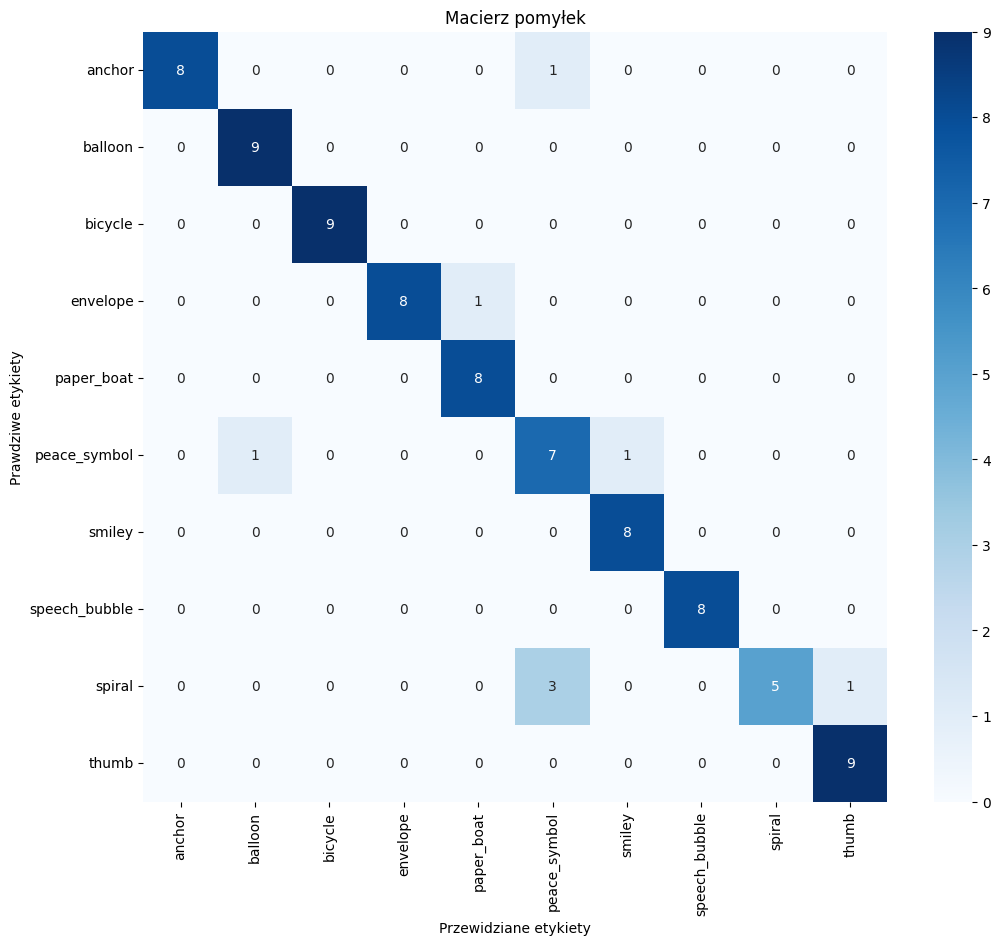

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

epochs = 100
patience = 20
learning_rate = 0.001

train_loader, val_loader, test_loader, class_names = get_dataloaders()

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
best_val_accuracy = 0.0
best_model_path = "best_model.pth"
epochs_no_improve = 0



# pętla treningowa
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _= evaluate(model, val_loader, criterion, device)

    # early stopping na najlepszym modelu
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoka [{epoch+1}/{epochs}] | "
            f"Strata treningowa: {train_loss:.4f}, Dokładność treningowa: {train_acc:.4f} | "
            f"Strata walidacyjna: {val_loss:.4f}, Dokładność walidacyjna: {val_acc:.4f}")
        print(f"Zapisano nowy najlepszy model z dokładnością: {best_val_accuracy:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience and epoch > 30: # niech zrobi co najmniej 30 epok za każdym razem
            print(f"\nEarly stopping, brak poprawy przez {patience} epok.")
            break


model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)
print(f"\nOstateczna strata na zbiorze testowym: {test_loss:.4f}")
print(f"Ostateczna dokładność na zbiorze testowym: {test_acc:.4f}")

# --- Obliczanie i wyświetlanie macierzy pomyłek ---
cm = confusion_matrix(all_labels, all_preds)
print("\nMacierz pomyłek:")
print(cm)

# --- Obliczanie i wyświetlanie raportu klasyfikacji (w tym precyzji) ---
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nRaport klasyfikacji (precyzja, czułość, f1-score):")
print(report)

# --- Wizualizacja macierzy pomyłek ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Przewidziane etykiety')
plt.ylabel('Prawdziwe etykiety')
plt.title('Macierz pomyłek')
plt.show()

Ostateczna dokładność na zbiorze, który nie brał udziału w uczeniu wynosi nieco ponad 90% co nie jest najgorszym wynikiem. Macierz pomyłek pokazuje że na ogół model nauczył się klas dosyć dobrze (najgorzej poradził sobie z peace_symbol i spiral. Widać tu tendencję, że okrągłe symbole są największym problemem, co jest kolejną rzeczą do usprawnienia w przyszłości) co można też zobaczyć w raporcie chociażby z precyzji, gdzie te klasy ze sporą liczbą zaokrągleń osiągają najgorszy wynik, wciąż nadal większość powyżej 80/90%

## Krok 6: Sprawdzenie modelu:
Zrobiłem specjalny folder, gdzie umieściłem zdjęcia do predykcji. Zobaczmy jak nasz model sobie poradzi

C:\Users\RODO\AppData\Local\Temp\ipykernel_3404\217974788.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

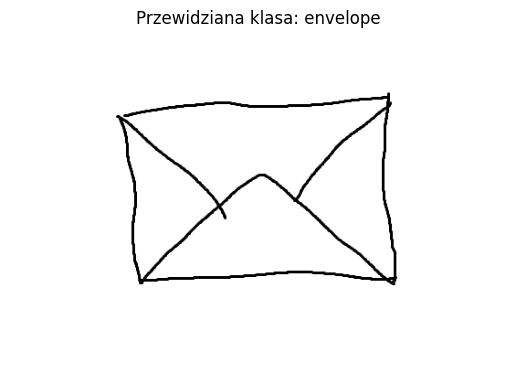

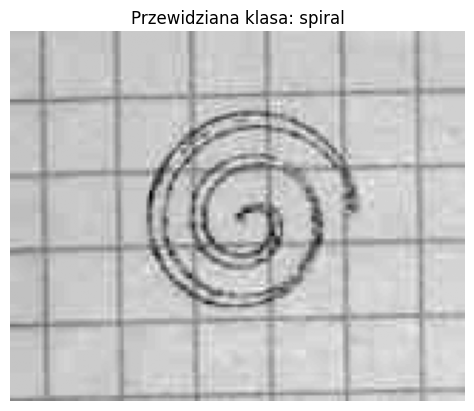

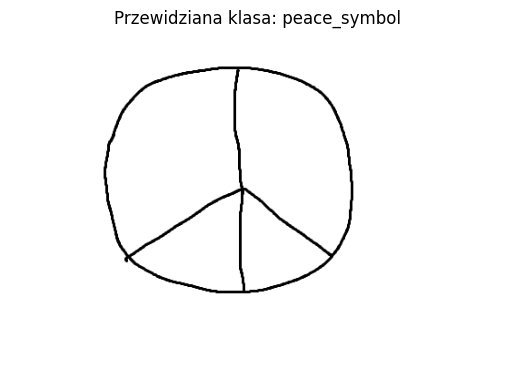

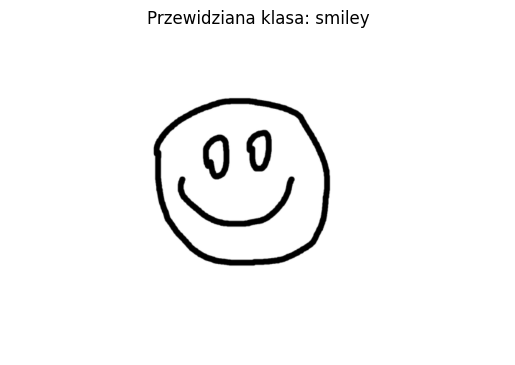

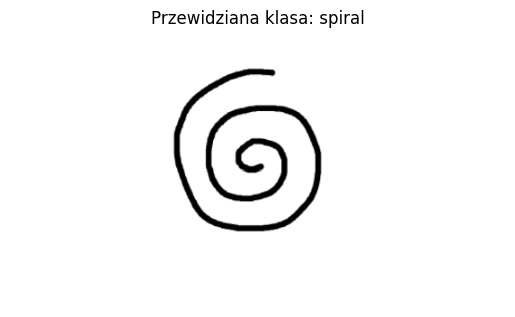

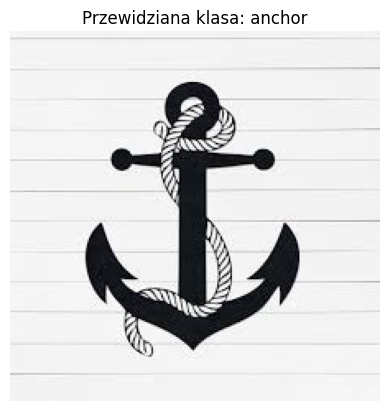

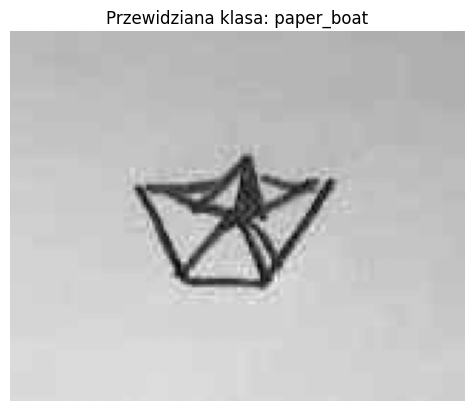

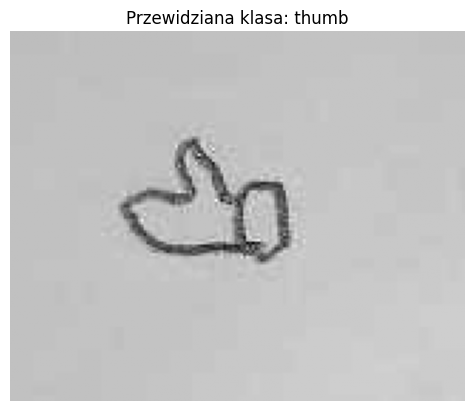

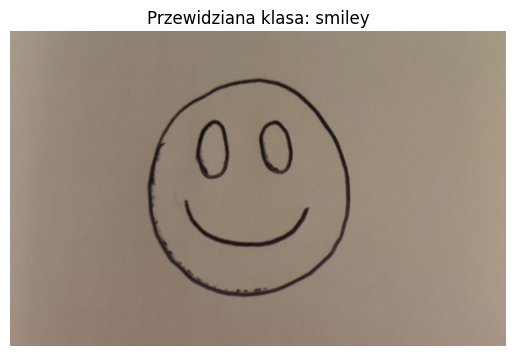

In [35]:
# Ścieżki
model_path = "THE_BEST_model.pth"   # zapisałem sobie jeden z lepszych modeli jaki narazie wyszedł, best_model.pth to model najnowszy do testowania i poprawiania
new_images_dir = "new_images"

# Transformacje
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Lambda(remove_grid_fft),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),
    transforms.Normalize((0.5,), (0.5,))
])

# Pobieramy nazwy klas
try:
    temp_dataset = SymbolDataset(root_dir=dataset_dir)
    class_names = temp_dataset.classes
except Exception:
    class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])


def classify_and_display_images(images_dir, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)) 
    model.eval()

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_name in image_files:
        image_path = os.path.join(images_dir, image_name)
        
        # Otwieranie i transformacja obrazu
        img_for_display = Image.open(image_path)
        img_for_model = img_for_display.convert("L")
        transformed_img = transform(img_for_model)
        image_batch = transformed_img.unsqueeze(0).to(device)

        # Predykcja
        with torch.no_grad():
            output = model(image_batch)
            _, predicted_idx = torch.max(output, 1)
            predicted_class = class_names[predicted_idx.item()]

        # Wyświetlanie wyniku
        plt.figure()
        plt.imshow(img_for_display,cmap='gray')
        plt.title(f"Przewidziana klasa: {predicted_class}")
        plt.axis('off')
        plt.show()

classify_and_display_images(new_images_dir, model_path)

Większość zdjęć zrobiłem w paintcie, jedno jest zrobione na kartce i dla formalności sprawdziłem też zdjęcia z datasetu, wszystkie zostały poprawnie odgadnięte przez model. Symbole z niewielką ilością szumu są rozpoznawane w miarę poprawnie, ale te, robione na kartce, są dalej trudne dla modelu i nie zawsze on daje sobie radę
Jeżeli ktoś się mocno przyjży, to zauważy że przy transformacji nowych zdjęć, użyłem nieco zmienionej funkcji a mianowicie usunąłem morfologię i zmniejszyłem próg binaryzacji. Testowałem oba warianty i doszedłem do wniosku, że użycie morfologi jeszcze polepsza zdjęcia które nie miały za dużo szumu (różnica w jasności między kratką a symbolem była znacząca) natomiast mocno psuła te złe zdjęcia. Brak morfologii z kolei dawał lepszy rezultat dla zdjęć słabych, ale te mniej zaszumione też obrywały i traciły na jakości. Po przetestowaniu obu sposobów na dużej części zdjęć, również z datasetu podjąłem decyzję, że dla uczenia lepiej użyć tej z morfologią (dawało to lepsze wyniki w predykcji) natomiast nowe zdjęcia przechodzą bez morfologii i taka konfiguracja działała najlepiej.

##  Wnioski:
W trakcie tworzenia modelu bardziej kierowałem się ideą niż wykręceniem najwyższego wyniku. Bardzo zależało mi na pozbyciu się kratek z zeszytów niestety kosztem niektórych zdjęć. Jak już wspominałem kombinowałem z optuną ale no na laptopie to szło tak topornie, a wynik i tak nie dawał zadowalających rezultatów także te hiperparametry wybrałem empirycznie, ogółem model wykręcił nie najgorszy wynik biorąc pod uwagę jak zaszumiony i mały był zbiór danych. Model w pewnym stopniu działa, ma problemy najczęściej zaokrągleniami (spirala, znak pokoju i buźka) ale i tak pewien i nawet nie aż tak niski procent zdjęć zgaduje poprawnie więc jakiś sukces jest. Co do modelu to testowałem jeszcze restneta ale wyniki był dalekie od dobrych, co prawda model pokazywał, że na danych testowych osiąga 97% accuracy ale to był wyłącznie efekt przeuczenia i na zdjęciach nie z datasetu model się kompletnie wykrzaczał. Testowałem też inne podejścia do cnn, dodawałem i odejmowałem warstwy, lekko je edytowałem ale nic nie dało mi lepszego wyniku na danych nie ze zbioru jak to co pokazałem.
